#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor 
from statsmodels.tsa.seasonal import seasonal_decompose
from phik import phik_matrix

In [2]:
RANDOM_STATE = 41
TEST_SIZE = 0.1

## Подготовка

### Загрузка данных

In [3]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Ресемплирование

In [6]:
data = data.resample('1H').sum()

C:\Users\kapit\AppData\Local\Temp\ipykernel_20940\2814516379.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [9]:
decomposed = seasonal_decompose(data)

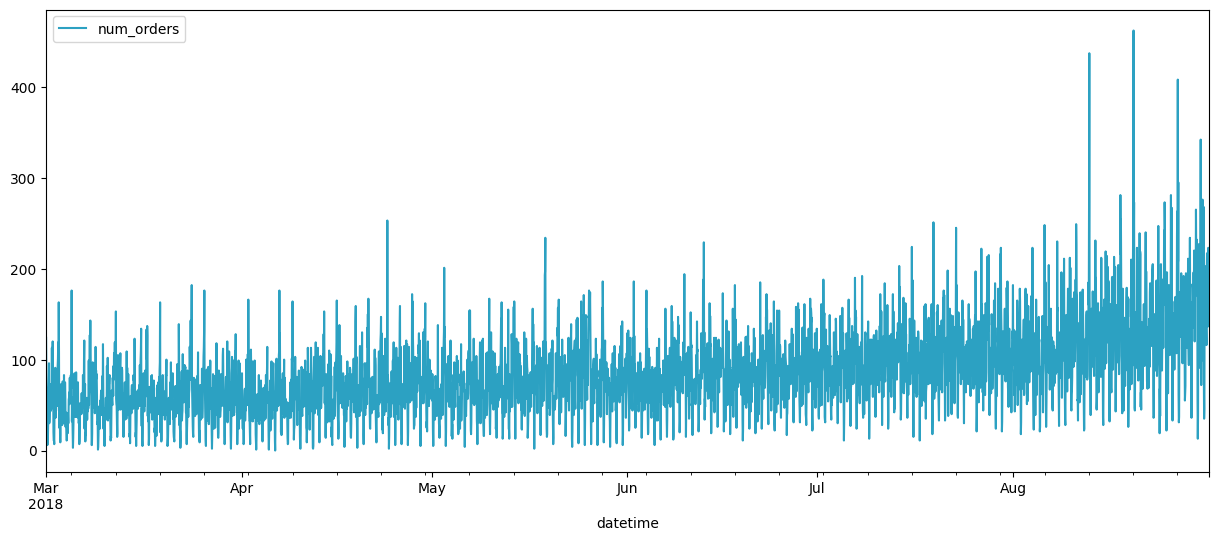

In [10]:
data.plot(figsize=(15, 6), color=sns.color_palette('YlGnBu')[3]);

**Тренд:**

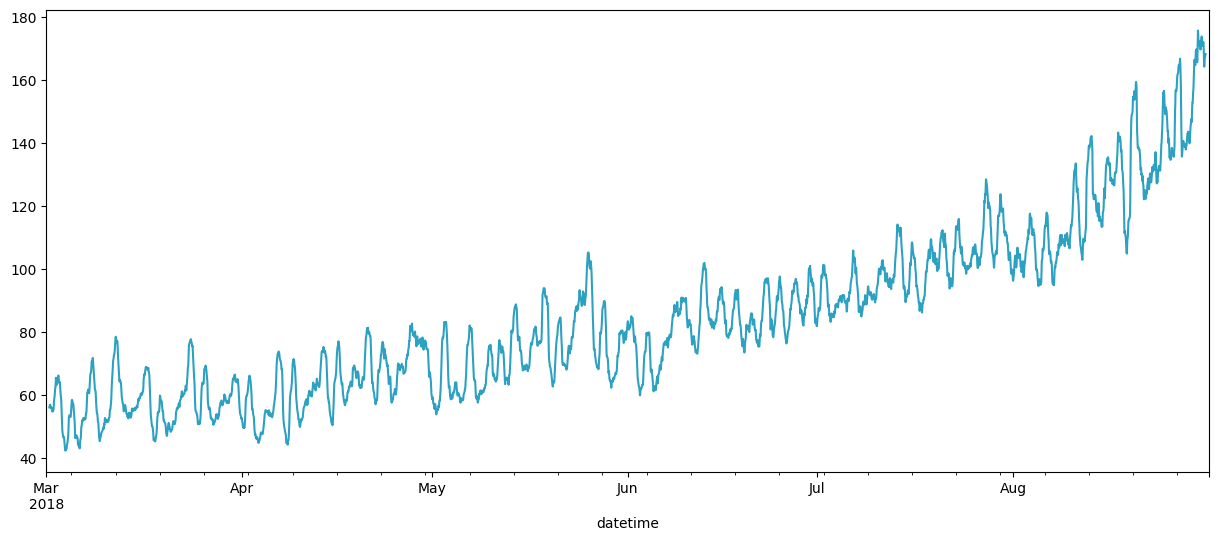

In [11]:
decomposed.trend.plot(figsize=(15, 6), color=sns.color_palette('YlGnBu')[3]);

**Сезонность:**

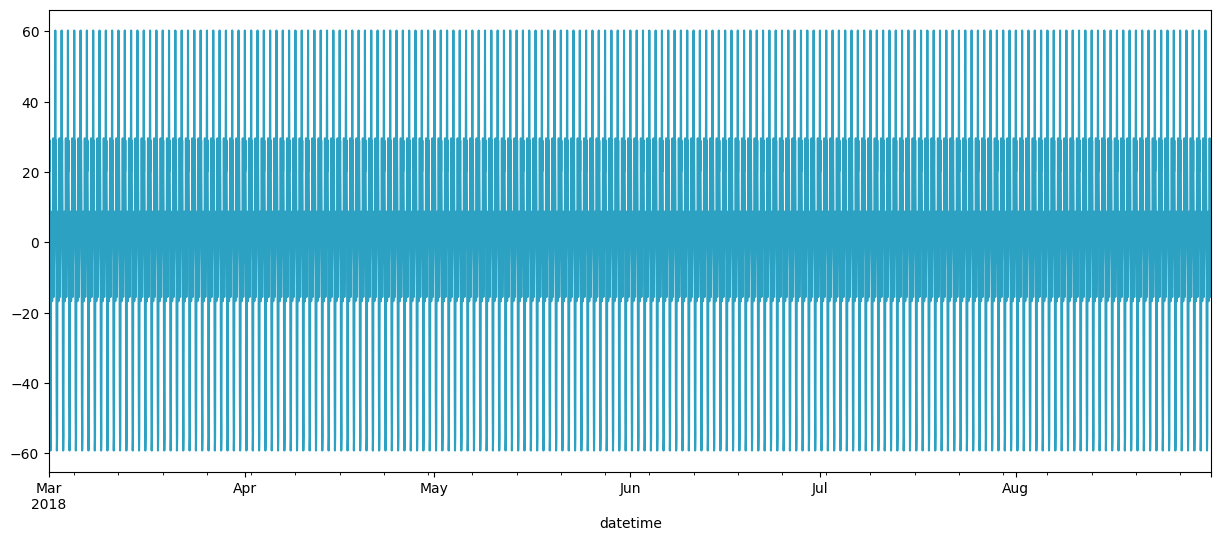

In [12]:
decomposed.seasonal.plot(figsize=(15, 6), color=sns.color_palette('YlGnBu')[3]);

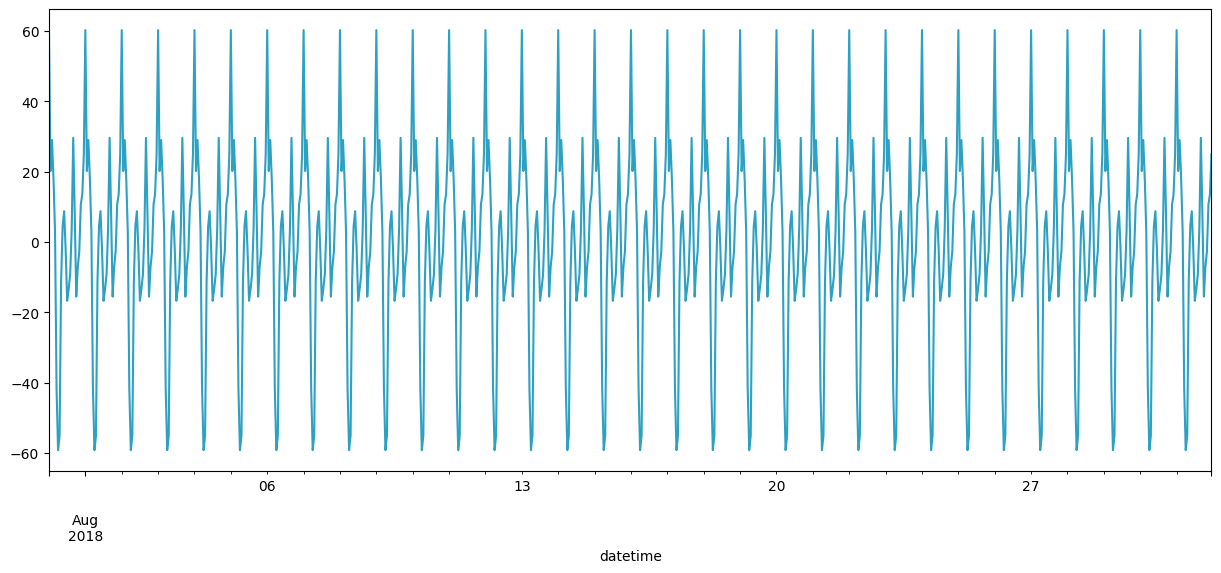

In [13]:
decomposed.seasonal['2018-07-31':'2018-08-31'].plot(figsize=(15, 6), color=sns.color_palette('YlGnBu')[3]);

**Остаток:**

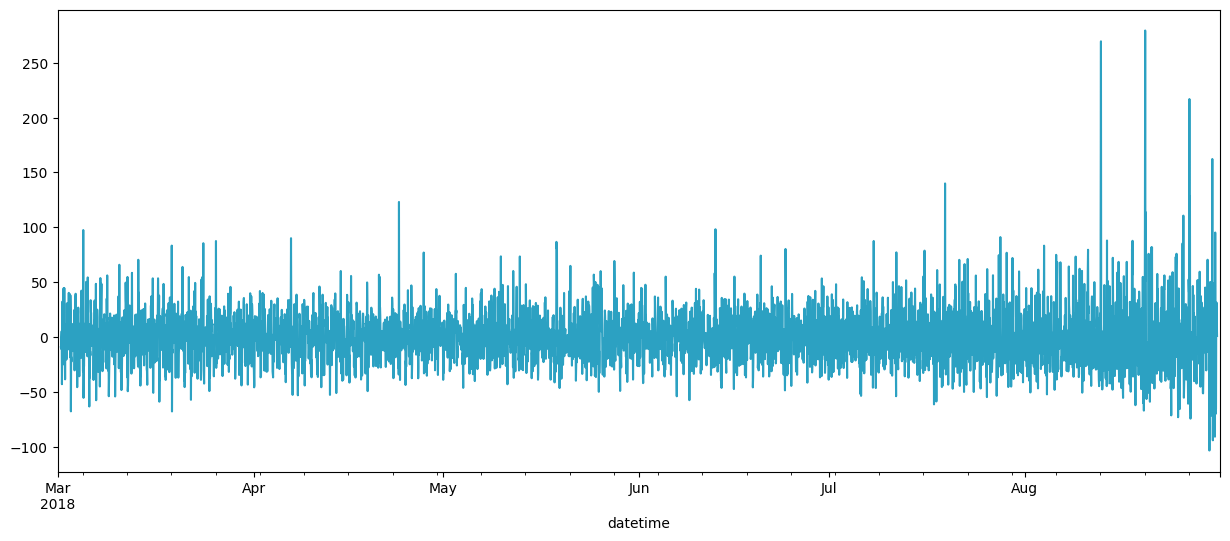

In [14]:
decomposed.resid.plot(figsize=(15, 6), color=sns.color_palette('YlGnBu')[3]);

### Вывод

Наблюдается тренд увеличения заказов такси с течением года в несколько раз. Так же имеется сезонность, рост заказов растет по утрам, достигает пика ближе к вечеру и падает после полуночи. 

## Обучение

### Создание новых признаков

In [15]:
def make_df(df):
    df = df.copy(deep=True)
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    df['lag_1'] = df['num_orders'].shift(1)
    df['lag_12'] = df['num_orders'].shift(12)
    df['lag_24'] = df['num_orders'].shift(24)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
    
    return df

In [16]:
test_data = make_df(data)

In [17]:
test_data = test_data.dropna()

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   hour          4392 non-null   int32  
 2   dayofweek     4392 non-null   int32  
 3   lag_1         4392 non-null   float64
 4   lag_12        4392 non-null   float64
 5   lag_24        4392 non-null   float64
 6   rolling_mean  4392 non-null   float64
dtypes: float64(4), int32(2), int64(1)
memory usage: 240.2 KB


In [19]:
test_data.head()

,num_orders,hour,dayofweek,lag_1,lag_12,lag_24,rolling_mean
datetime,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,30.0,124.0,56.833333
2018-03-02 01:00:00,120,1,4,90.0,32.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,48.0,71.0,56.875000
2018-03-02 03:00:00,64,3,4,75.0,66.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,43.0,43.0,56.958333


### Подготовка к обучению

#### Создание метрики

In [20]:
def rmse_scorer(pred, true):
    return root_mean_squared_error(pred, true)

rmse = make_scorer(rmse_scorer, greater_is_better=False)

#### Формирование выборок

In [21]:
X = test_data.drop('num_orders', axis=1)
y = test_data['num_orders']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [23]:
tscv = TimeSeriesSplit(n_splits=10)

#### Создание пайплайна для подбора моделей и параметров

In [24]:
num_cols = ['lag_1', 'lag_12', 'lag_24', 'rolling_mean']
cat_cols = ['hour', 'dayofweek']

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_cols),
        ('cat', 'passthrough', cat_cols)
    ]
)

final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__cat': [OneHotEncoder(drop='first')]
    },
    {
        'models': [LGBMRegressor()],
        'models__max_depth': range(1, 10, 2),
        'preprocessor__cat': [OrdinalEncoder()]        
    },
    
    {
        'models': [DecisionTreeRegressor()],
        'models__max_depth': range(1, 10, 2),
        'models__max_features': range(1, 6),
        'preprocessor__cat': [OrdinalEncoder()] 
    }
]

random_search = RandomizedSearchCV(
    final_pipe,
    param_grid,
    scoring=rmse,
    cv=tscv,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

### Подбор и обучение модели

#### Обучение

In [25]:
result = random_search.fit(X_train, y_train)
result.best_score_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 6
[LightGBM] [Info] Start training from score 78.451417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

np.float64(-24.019600816249955)

#### Лучшая модель

In [26]:
pd.DataFrame(result.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__cat,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5,0.270314,0.046500,0.005990,0.001000,OrdinalEncoder(),NaN,9,LGBMRegressor(),"{'preprocessor__cat': OrdinalEncoder(), 'model...",-19.761941,...,-22.737856,-24.814409,-23.674400,-22.998082,-24.613699,-27.237083,-31.069081,-24.019601,3.128199,1
3,0.008280,0.001014,0.003778,0.000557,OrdinalEncoder(),5.0,5,DecisionTreeRegressor(),"{'preprocessor__cat': OrdinalEncoder(), 'model...",-21.815106,...,-24.949807,-27.976233,-24.802242,-25.413162,-28.837845,-34.459264,-38.410877,-27.605552,4.943655,2
6,0.009000,0.002145,0.003700,0.000641,OrdinalEncoder(),5.0,7,DecisionTreeRegressor(),"{'preprocessor__cat': OrdinalEncoder(), 'model...",-23.621400,...,-25.027442,-29.473517,-26.673407,-26.671805,-28.495687,-34.329183,-39.041478,-28.424545,4.637442,3
7,0.007000,0.001000,0.004000,0.000633,OrdinalEncoder(),4.0,3,DecisionTreeRegressor(),"{'preprocessor__cat': OrdinalEncoder(), 'model...",-21.366315,...,-25.036542,-30.004494,-27.727555,-26.548135,-31.465937,-36.392491,-42.325861,-29.253716,5.899562,4
4,0.007888,0.001560,0.003656,0.000437,OrdinalEncoder(),2.0,9,DecisionTreeRegressor(),"{'preprocessor__cat': OrdinalEncoder(), 'model...",-26.794141,...,-25.918197,-27.674442,-27.291044,-29.475837,-30.908903,-33.199054,-39.047147,-29.335012,4.048765,5


In [27]:
model = result.best_estimator_

In [28]:
model.named_steps['models']

LGBMRegressor(max_depth=9)

#### Важность признаков

C:\Users\kapit\AppData\Local\Temp\ipykernel_20940\1829821018.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), palette='YlGnBu')


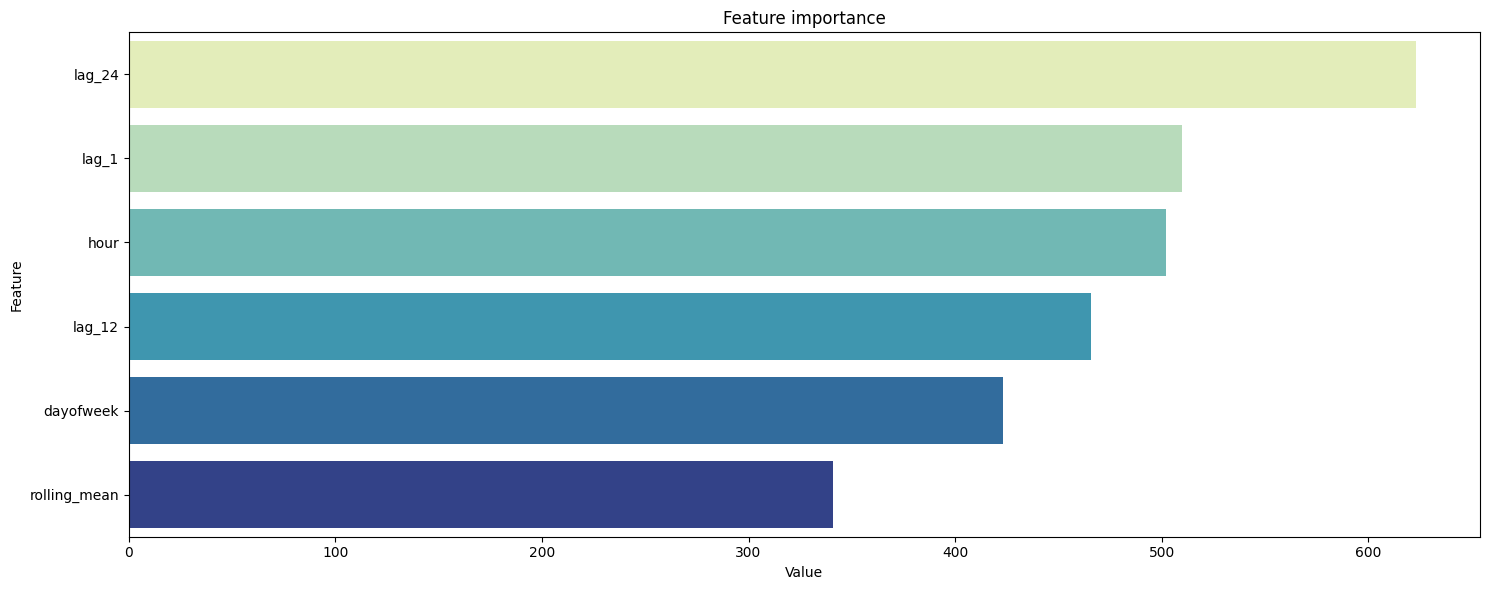

In [29]:
plt.figure(figsize=(15,6), dpi=100)
feature_importance = model.named_steps['models'].feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, X_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), palette='YlGnBu')
plt.title('Feature importance')
plt.tight_layout()
plt.show(); 

### Вывод

Был создан пайплайн для поиска лучшей модели и подбора гиперпараметров между LinearRegression, LGBMRegressor, DecisionTreeRegressor. Лучшая модель на кросс-валидации - **LGBMRegressor(max_depth=9)** с RMSE -24.01.

## Тестирование

In [30]:
pred = model.predict(X_test)
root_mean_squared_error(y_test, pred)

c:\Users\kapit\Desktop\Разные файлы\Python\Practicum_GIT\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


43.33804255739681

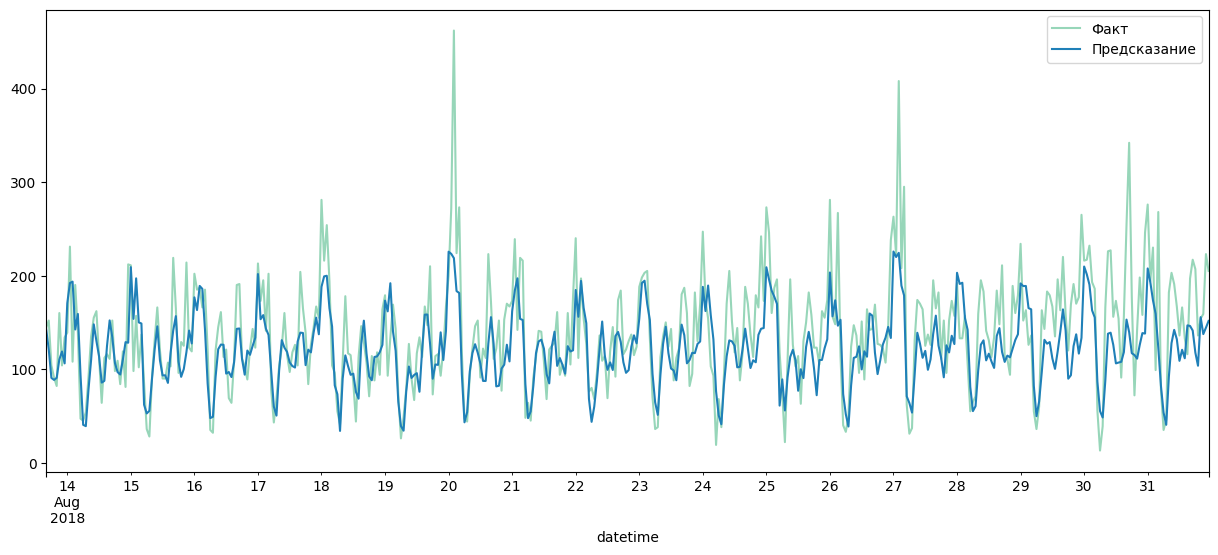

In [31]:
pd.DataFrame({'Факт': y_test, 'Предсказание': pred}).plot(figsize=(15, 6), color=sns.color_palette('YlGnBu', n_colors=2));

### Вывод

На тестовой выборке модель показала RMSE 43.33, что в 2 раза хуже чем на кросс-валидации, но укладывается в требование - RMSE не более 48. В тестовую выборку попали данные относящиеся ко второй половине августа. Из-за того что в данных наблюдается ярко выраженная тенденция роста ближе к концу лета и этот рост ускоряется, то модель хуже предсказывает этот период, отсюда, вероятнее всего, RMSE заметно хуже чем на кросс-валидации.   